# Exercise Generation script from the Tatoeba database

In [2]:
import pandas as pd
from tqdm import tqdm
import missingno as msno

import spacy

import pickle

nlp_en = spacy.load("en_core_web_sm")
nlp_pt = spacy.load("pt_core_news_sm")

The Data comes from Tatoeba and is the list in tsv format of the sentences in the target language and their traduction in the source language. The data is available here: https://tatoeba.org/eng/downloads

In [3]:
english_words = pd.read_csv("../../data/english_corpus.tsv", sep="\t")["English Word"].astype(str).to_list()

tatoebaJapDf = pd.read_csv("../../data/tatoeba - English-Japanese - 2022-10-14.tsv", sep="\t", header=None, on_bad_lines="skip")
tatoebaJapDf.columns = ["English ID", "English sentence", "Japanese ID", "Japanese sentence"]

tatoebaPorDf = pd.read_csv("../../data/tatoeba - English-Portuguese - 2022-10-14.tsv", sep="\t", header=None, on_bad_lines="skip")
tatoebaPorDf.columns = ["English ID", "English sentence", "Portuguese ID", "Portuguese sentence"]

tatoebaTurDf = pd.read_csv("../../data/tatoeba - English-Turkish - 2022-10-28.tsv", sep="\t", header=None, on_bad_lines="skip")
tatoebaTurDf.columns = ["English ID", "English sentence", "Turkish ID", "Turkish sentence"]

print(len(english_words))


6003


We filter out any of the words that do not make sense

In [4]:
english_words_filtered = [word for word in english_words if (" " not in word) and ("(" not in word) and ("?" not in word)]
print(len(english_words_filtered))
english_words_filtered.sort()

lemmatized_english_words = [nlp_en(word)[0].lemma_ for word in tqdm(english_words_filtered)]
print(len(lemmatized_english_words))
lemmatized_english_words

4450


100%|██████████| 4450/4450 [00:14<00:00, 303.61it/s]


4450


['AIDS',
 'Abandon',
 'abandon',
 'abbreviation',
 'abdoman',
 'ability',
 'ablution',
 'about',
 'about',
 'above',
 'abrupt',
 'abscess',
 'absence',
 'absent',
 'absolute',
 'absolutely',
 'absorption',
 'abstention',
 'abstract',
 'absurd',
 'absurd',
 'absurd',
 'abuse',
 'academic',
 'academy',
 'acceleration',
 'accent',
 'accident',
 'Accidental',
 'accomplice',
 'accord',
 'accordion',
 'accountant',
 'accounting',
 'accurate',
 'accuse',
 'accustomed',
 'achievable',
 'acid',
 'acidity',
 'acne',
 'Acrobat',
 'across',
 'action',
 'active',
 'activist',
 'activity',
 'actor',
 'actress',
 'acupuncture',
 'add',
 'addict',
 'addiction',
 'address',
 'adjective',
 'administration',
 'administration',
 'administrative',
 'admire',
 'adolescence',
 'adolescence',
 'adorable',
 'adult',
 'advantage',
 'advantageous',
 'Adverb',
 'advertising',
 'advice',
 'aerodrome',
 'aerodrome',
 'aerosol',
 'aerospace',
 'aerospatial',
 'affect',
 'affectionately',
 'afghan',
 'Afghanistan',
 

Lemmatization of the words in the sentences of tatoeba to be able to match them.
This can take 15mins so we save the result in a file

In [21]:
list_of_lemma_in_english_sentences = []
for sentence in tqdm(tatoebaPorDf["English sentence"]):
    list_of_lemma_in_english_sentences.append([x.lemma_ for x in nlp_en(sentence)])
pickle.dump(list_of_lemma_in_english_sentences, open("list_of_lemma_in_english_sentences-por.pkl", "wb"))


100%|██████████| 268460/268460 [17:18<00:00, 258.44it/s]


In [22]:
list_of_lemma_in_english_sentences = []
for sentence in tqdm(tatoebaTurDf["English sentence"]):
    list_of_lemma_in_english_sentences.append([x.lemma_ for x in nlp_en(sentence)])
pickle.dump(list_of_lemma_in_english_sentences, open("list_of_lemma_in_english_sentences-tur.pkl", "wb"))

100%|██████████| 698717/698717 [45:39<00:00, 255.08it/s]  


In [ ]:
english_target_sentences = []

list_of_lemma_in_english_sentences = pickle.load(open("list_of_lemma_in_english_sentences-por.pkl", "rb"))
lower_list_of_lemma_in_english_sentences = [[word.lower() for word in sentence] for sentence in list_of_lemma_in_english_sentences]

for english_word in tqdm(english_words_filtered):
    lemma = nlp_en(english_word)[0].lemma_
    lemma_lower = lemma.lower()

    # This is the most important line that finds the sentences that contain the word.
    # It only works because the lemmatized sentences are in the same order and have the same index as the original sentences.
    sentencesContainingEnWord = [{"source": tatoebaPorDf.loc[tatoebaPorDf.index[idx], "English sentence"], "target": tatoebaPorDf.loc[tatoebaPorDf.index[idx], "Portuguese sentence"]} for idx, sentence in enumerate(lower_list_of_lemma_in_english_sentences) if lemma_lower in sentence]

    # Filter to have better sentences
    sentencesContainingEnWord = [sentence for sentence in sentencesContainingEnWord if len(sentence["source"]) > 2 and len(sentence["source"]) < 21]

    if len(sentencesContainingEnWord) > 0:
        sentencesContainingEnWord.sort(key=lambda s: len(s["source"]))
        english_target_sentences.append({
            "English Word": english_word,
            "English Lemma": lemma,
            "Short English Sentence": sentencesContainingEnWord[0]["source"],
            "Long English Sentence": sentencesContainingEnWord[-1]["source"],
            "Short Target Sentence": sentencesContainingEnWord[0]["target"],
            "Long Target Sentence": sentencesContainingEnWord[-1]["target"],
        })
    else :
        english_target_sentences.append({
            "English Word": english_word,
            "English Lemma": lemma,
            "Short English Sentence": pd.NA,
            "Long English Sentence": pd.NA,
            "Short Target Sentence": pd.NA,
            "Long Target Sentence": pd.NA,
        })

result = pd.DataFrame(english_target_sentences)
result.to_csv("../../data/corpus/english_portuguese_corpus.tsv", sep="\t", index=False)

In [23]:
english_target_sentences = []

list_of_lemma_in_english_sentences = pickle.load(open("list_of_lemma_in_english_sentences-tur.pkl", "rb"))
lower_list_of_lemma_in_english_sentences = [[word.lower() for word in sentence] for sentence in list_of_lemma_in_english_sentences]

for english_word in tqdm(english_words_filtered):
    lemma = nlp_en(english_word)[0].lemma_
    lemma_lower = lemma.lower()

    # This is the most important line that finds the sentences that contain the word.
    # It only works because the lemmatized sentences are in the same order and have the same index as the original sentences.
    sentencesContainingEnWord = [{"source": tatoebaTurDf.loc[tatoebaTurDf.index[idx], "English sentence"], "target": tatoebaTurDf.loc[tatoebaTurDf.index[idx], "Turkish sentence"]} for idx, sentence in enumerate(lower_list_of_lemma_in_english_sentences) if lemma_lower in sentence]

    # Filter to have better sentences
    sentencesContainingEnWord = [sentence for sentence in sentencesContainingEnWord if len(sentence["source"]) > 2 and len(sentence["source"]) < 21]

    if len(sentencesContainingEnWord) > 0:
        sentencesContainingEnWord.sort(key=lambda s: len(s["source"]))
        english_target_sentences.append({
            "English Word": english_word,
            "English Lemma": lemma,
            "Short English Sentence": sentencesContainingEnWord[0]["source"],
            "Long English Sentence": sentencesContainingEnWord[-1]["source"],
            "Short Target Sentence": sentencesContainingEnWord[0]["target"],
            "Long Target Sentence": sentencesContainingEnWord[-1]["target"],
        })
    else :
        english_target_sentences.append({
            "English Word": english_word,
            "English Lemma": lemma,
            "Short English Sentence": pd.NA,
            "Long English Sentence": pd.NA,
            "Short Target Sentence": pd.NA,
            "Long Target Sentence": pd.NA,
        })

result = pd.DataFrame(english_target_sentences)
result.to_csv("../../data/corpus/english_turkish_corpus.tsv", sep="\t", index=False)

100%|██████████| 4450/4450 [43:09<00:00,  1.72it/s]     


## Assessing the quality of the results

In [31]:
english_portuguese_corpus = pd.read_csv("../../data/corpus/english_portuguese_corpus.tsv", sep="\t").drop_duplicates()
english_portuguese_corpus

,English Word,English Lemma,Short English Sentence,Long English Sentence,Short Target Sentence,Long Target Sentence
0,AIDS,AIDS,NaN,NaN,NaN,NaN
1,Abandon,Abandon,Abandon ship!,Father abandoned us.,Abandonar o navio!,O pai nos abandonou.
2,Abandoned,abandon,Abandon ship!,Father abandoned us.,Abandonar o navio!,O pai nos abandonou.
3,Abbreviation,abbreviation,NaN,NaN,NaN,NaN
4,Abdomen,abdoman,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
4441,illiteracy,illiteracy,NaN,NaN,NaN,NaN
4442,lucrative,lucrative,NaN,NaN,NaN,NaN
4443,NaN,NaN,NaN,NaN,NaN,NaN
4447,wrong,wrong,Wrong.,Tom was wrong again.,Errado.,Tom estava errado de novo.


<AxesSubplot:>

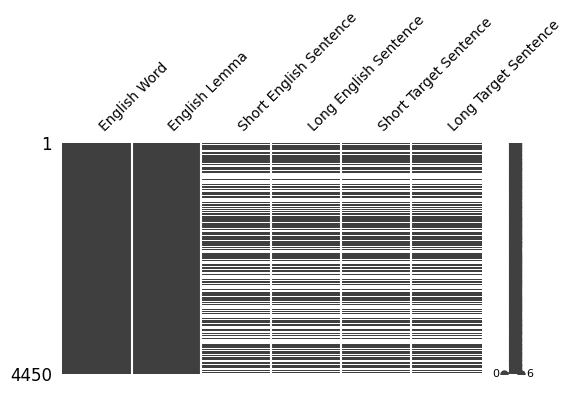

In [16]:
msno.matrix(english_portuguese_corpus, figsize=(6, 3), fontsize=10)

In [17]:
print(english_portuguese_corpus.count())

counter = 0
for idx, row in english_portuguese_corpus.iterrows():
    if row["Short English Sentence"] is row["Long English Sentence"] and type(row["Short English Sentence"]) is str:
        print(row["English Word"], row["English Lemma"], row["Short English Sentence"], row["Short Target Sentence"])
        counter += 1
print("Number of words with only one sentence:", counter)


English Word              4446
English Lemma             4446
Short English Sentence    2291
Long English Sentence     2291
Short Target Sentence     2291
Long Target Sentence      2291
dtype: int64
Number of words with only one sentence: 0


In [25]:
english_turkish_corpus = pd.read_csv("../../data/corpus/english_turkish_corpus.tsv", sep="\t")
english_turkish_corpus

,English Word,English Lemma,Short English Sentence,Long English Sentence,Short Target Sentence,Long Target Sentence
0,AIDS,AIDS,I had an AIDS test.,I had an AIDS test.,AIDS testi yaptırdım.,AIDS testi yaptırdım.
1,Abandon,Abandon,Abandon ship!,Father abandoned us.,Gemiyi boşaltın!,Babam bizi terk etti.
2,Abandoned,abandon,Abandon ship!,Father abandoned us.,Gemiyi boşaltın!,Babam bizi terk etti.
3,Abbreviation,abbreviation,NaN,NaN,NaN,NaN
4,Abdomen,abdoman,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
4445,NaN,NaN,NaN,NaN,NaN,NaN
4446,NaN,NaN,NaN,NaN,NaN,NaN
4447,wrong,wrong,Wrong.,I know Tom is wrong.,Yanlış.,Tom'un hatalı olduğunu biliyorum.
4448,wrong,wrong,Wrong.,I know Tom is wrong.,Yanlış.,Tom'un hatalı olduğunu biliyorum.


<AxesSubplot:>

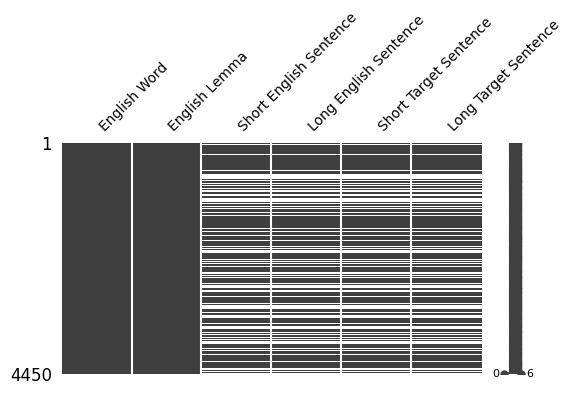

In [28]:
msno.matrix(english_turkish_corpus, figsize=(6, 3), fontsize=10)

In [29]:
print(english_turkish_corpus.count())

counter = 0
for idx, row in english_turkish_corpus.iterrows():
    if row["Short English Sentence"] is row["Long English Sentence"] and type(row["Short English Sentence"]) is str:
        print(row["English Word"], row["English Lemma"], row["Short English Sentence"], row["Short Target Sentence"])
        counter += 1
print("Number of words with only one sentence:", counter)

English Word              4446
English Lemma             4446
Short English Sentence    2778
Long English Sentence     2778
Short Target Sentence     2778
Long Target Sentence      2778
dtype: int64
Number of words with only one sentence: 0


## Getting the translation for the target words

In [4]:
from googletrans import Translator # Library only works in alpha: pip install googletrans==3.1.0a0
translator = Translator()

In [5]:
translated_lemmatized_english_words = [translator.translate(word, src="en", dest="pt").text for word in tqdm(lemmatized_english_words)]
translated_lemmatized_english_words

100%|██████████| 4450/4450 [05:56<00:00, 12.49it/s]


['AUXILIA',
 'Abandono',
 'abandono',
 'abreviação',
 'abdômen',
 'habilidade',
 'ablução',
 'cerca de',
 'cerca de',
 'acima de',
 'abrupto',
 'abscesso',
 'ausência',
 'ausente',
 'absoluto',
 'absolutamente',
 'absorção',
 'abstenção',
 'abstrato',
 'absurdo',
 'absurdo',
 'absurdo',
 'Abuso',
 'acadêmico',
 'Academia',
 'aceleração',
 'sotaque',
 'acidente',
 'Acidental',
 'cúmplice',
 'acordo',
 'acordeão',
 'contador',
 'contabilidade',
 'exato',
 'acusar',
 'acostumado',
 'alcançável',
 'ácido',
 'acidez',
 'acne',
 'Acrobata',
 'através',
 'ação',
 'ativo',
 'ativista',
 'atividade',
 'ator',
 'atriz',
 'acupuntura',
 'adicionar',
 'viciado',
 'vício',
 'Morada',
 'adjetivo',
 'administração',
 'administração',
 'administrativo',
 'admirar',
 'adolescência',
 'adolescência',
 'adorável',
 'adulto',
 'vantagem',
 'vantajoso',
 'Advérbio',
 'publicidade',
 'adendo',
 'aeródromo',
 'aeródromo',
 'aerossol',
 'aeroespacial',
 'aeroespacial',
 'afetar',
 'carinhosamente',
 'afegão',

In [ ]:
to_save = pd.DataFrame({"English Lemma": lemmatized_english_words, "Portuguese Translation": translated_lemmatized_english_words})
to_save.to_csv("../../data/corpus/english_portuguese_translations.tsv", sep="\t", index=False)

In [12]:
en_pt_translated = pd.read_csv("../../data/corpus/english_portuguese_translations.tsv", sep="\t")
en_pt_translated

,English Lemma,Portuguese Translation
0,AIDS,AUXILIA
1,Abandon,Abandono
2,abandon,abandono
3,abbreviation,abreviação
4,abdoman,abdômen
...,...,...
4445,NaN,NaN
4446,NaN,NaN
4447,wrong,errado
4448,wrong,errado


# Finding the sentences that contain the translated words


In [53]:
resultDf = []

for idx, target_word in tqdm(enumerate(en_pt_translated["Portuguese Translation"].values)):
    if type(target_word) is str:
        matching_sentences = []
        for en_sentence, pt_sentence in tatoebaPorDf[["English sentence", "Portuguese sentence"]].values:
            if target_word in str(pt_sentence).replace(".", "").split(" "):
                matching_sentences.append({"source": en_sentence, "target": pt_sentence})
        if len(matching_sentences) > 0:
            matching_sentences.sort(key=lambda s: len(s["source"]))
            resultDf.append({
                "English Word": en_pt_translated.loc[en_pt_translated.index[idx], "English Lemma"],
                "Portuguese Translation": target_word,
                "Short English Sentence": matching_sentences[0]["source"],
                "Long English Sentence": matching_sentences[-1]["source"],
                "Short Target Sentence": matching_sentences[0]["target"],
                "Long Target Sentence": matching_sentences[-1]["target"],
            })
        else :
            resultDf.append({
                "English Word": en_pt_translated.loc[en_pt_translated.index[idx], "English Lemma"],
                "Portuguese Translation": target_word,
                "Short English Sentence": pd.NA,
                "Long English Sentence": pd.NA,
                "Short Target Sentence": pd.NA,
                "Long Target Sentence": pd.NA,
            })

result = pd.DataFrame(resultDf)
result.to_csv("../../data/corpus/english_portuguese_corpus-from_translate.tsv", sep="\t", index=False)

4450it [30:23,  2.44it/s]


<AxesSubplot:>

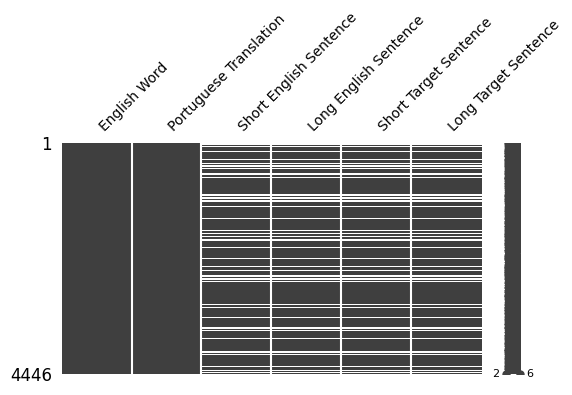

In [57]:
msno.matrix(result, figsize=(6, 3), fontsize=10)

In [56]:
result.count()

English Word              4446
Portuguese Translation    4446
Short English Sentence    3444
Long English Sentence     3444
Short Target Sentence     3444
Long Target Sentence      3444
dtype: int64

In [54]:
# In the long sentences, there can be multiple sentences.
# We want to have only one sentence per row. So we split the sentences by the dot and keep only the one containing the target word.
for idx, row in result.iterrows():
    if type(row["Long Target Sentence"]) is str:
        sentences = row["Long Target Sentence"].split(".")
        for sentence in sentences:
            if row["Portuguese Translation"] in sentence:
                result.loc[idx, "Long Target Sentence"] = sentence
                break
    if type(row["Long English Sentence"]) is str:
        sentences = row["Long English Sentence"].split(".")
        for sentence in sentences:
            if row["English Word"] in sentence:
                result.loc[idx, "Long English Sentence"] = sentence
                break
result.to_csv("../../data/corpus/english_portuguese_corpus-from_translate.tsv", sep="\t", index=False)

# Tagging the result

In [55]:
en_pt_from_trad = pd.read_csv("../../data/corpus/english_portuguese_corpus-from_translate.tsv", sep="\t")
en_pt_from_trad

,English Word,Portuguese Translation,Short English Sentence,Long English Sentence,Short Target Sentence,Long Target Sentence
0,AIDS,AUXILIA,NaN,NaN,NaN,NaN
1,Abandon,Abandono,NaN,NaN,NaN,NaN
2,abandon,abandono,There was a rhythm in my sleep. When I woke up...,"Why did I leave the abandonment of myself, in...",Houve um ritmo no meu sono. Quando acordei o p...,"Por que saí do abandono de mim mesmo, em que ..."
3,abbreviation,abreviação,Jim is short for James.,"The abbreviation of ""Chinese People's Politica...",Jim é a abreviação de James.,"A abreviação para ""Conferência Consultiva Polí..."
4,abdoman,abdômen,He hit him in the abdomen.,The doctor palpated my abdomen.,Ele o socou na altura do abdômen.,O doutor apalpou meu abdômen
...,...,...,...,...,...,...
4441,illiteracy,analfabetismo,NaN,NaN,NaN,NaN
4442,lucrative,lucrativo,How do you start a profitable blog in seven days?,How can Facebook be profitable if we don't hav...,Como começar um blog lucrativo em 7 dias?,Como o Facebook pode ser lucrativo se não temo...
4443,wrong,errado,I'm wrong.,But some foolish people have got hold of the ...,Estou errado.,Mas algumas pessoas insensatas agarraram-se a...
4444,wrong,errado,I'm wrong.,But some foolish people have got hold of the ...,Estou errado.,Mas algumas pessoas insensatas agarraram-se a...
